In [348]:
import pandas as pd
import numpy as np
import re
import nfl_data_py as nfl
import redis
import pickle
from plotnine import ggplot, aes, geom_point, geom_smooth

r = redis.Redis(host='localhost', port=6379)

number_of_teams = 10
is_flex = True
ppr = 1
rush_yards = 0.1
receiving_yards = 0.1
rush_td = 6
receiving_td = 6
pass_yards = 0.04
pass_td = 4
fmb = -2
interception = -2


In [349]:
## load the rosters
def load_rosters(year):
    roster_columns = ['player_id','season','team','player_name','position']
    retrieved_rosters = r.get(f"rosters_{year}:v1")

    if retrieved_rosters:
        print(f'data loaded from redis for {year}')
        return pickle.loads(retrieved_rosters)
    else:
        print(f'loading data from github for {year}')
        retrieved_rosters = nfl.import_rosters([year], roster_columns)
        r.set(f"rosters_{year}:v1", pickle.dumps(retrieved_rosters))
        return retrieved_rosters

rosters = {}
for year in range(2009,2024):
    rosters[year] = load_rosters(year)

all_rosters = pd.concat(rosters.values(), ignore_index=True)
all_rosters.rename(columns={'player_id': 'gsis_id', 'player_name': 'full_name'}, inplace=True)

print("**** all rosters top 25 ****")
print(all_rosters.head(10))

loading data from github for 2009
loading data from github for 2010
loading data from github for 2011
loading data from github for 2012
loading data from github for 2013
loading data from github for 2014
loading data from github for 2015
loading data from github for 2016
loading data from github for 2017
loading data from github for 2018
loading data from github for 2019
loading data from github for 2020
loading data from github for 2021
loading data from github for 2022
loading data from github for 2023
**** all rosters top 25 ****
      gsis_id  season team                    full_name position
0  00-0022018    2009  ARZ                  Ben Claxton        C
1  00-0025682    2009  ARZ                Lyle Sendlein        C
2  00-0025668    2009  ARZ                Michael Adams       CB
3  00-0019613    2009  ARZ                  Ralph Brown       CB
4  00-0023497    2009  ARZ              Bryant McFadden       CB
5  00-0026156    2009  ARZ  Dominique Rodgers-Cromartie       CB
6  00-

In [350]:
print(all_rosters['season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023]


In [351]:
pbp_columns = [
      "pass_attempt", "passer_player_id", "rusher_player_id",
      "receiver_player_id", "play_type", "game_id", "drive",
      "passer_player_name", "complete_pass", "yards_gained",
      "air_yards", "qb_hit", "interception", "touchdown",
      "yards_after_catch", "epa", "wpa", "air_epa", "air_wpa",
      "yac_epa", "yac_wpa", "rush_attempt", "rusher_player_name",
      "fumble", "receiver_player_name", "posteam", "defteam", "Season"]

def store_dataframe_in_redis(name, dataframe):
    r.delete(name)
    serialized_data = pickle.dumps(dataframe)
    r.set(name, serialized_data)

def fetch_dataframe_from_redis(name):
    serialized_data = r.get(name)

    if serialized_data:
      return pickle.loads(serialized_data)
    else:
      return None

def load_pbp(year):
    year_pbp = fetch_dataframe_from_redis(f"pbp_{year}:v1")

    if year_pbp is not None and year_pbp.empty == False:
        print(f'data loaded from redis for {year}')
        return year_pbp
    else:
      print(f'loading data from github for {year}')
      year_pbp = nfl.import_pbp_data([year])
      store_dataframe_in_redis(f'pbp_{year}:v1', year_pbp)
      return year_pbp

def find_player_name(player_names):
    if len(player_names) == 0:
        return "None"
    else:
        return player_names.value_counts().idxmax()
    
def calc_passing_splits(splits, pbp_df):
    pbp_df = pbp_df.copy()

    # Filter data for pass attempts and add the GameDrive column
    pbp_df = pbp_df[(pbp_df['pass_attempt'] == 1) & (pbp_df['play_type'] != 'No Play')]
    #pbp_df['GameDrive'] = pbp_df['game_id'].astype(str) + "-" + pbp_df['drive'].astype(str)
    pbp_df.loc[:, 'GameDrive'] = pbp_df['game_id'].astype(str) + "-" + pbp_df['drive'].astype(str)


    # Group by splits and compute statistics
    # This is a simple example to compute 'Attempts', more columns can be added similarly
    result = pbp_df.groupby(splits).agg(
        Player_Name = pd.NamedAgg(column='passer_player_name', aggfunc=find_player_name),
        Attempts = pd.NamedAgg(column='pass_attempt', aggfunc='count'),
        Completions = pd.NamedAgg(column='complete_pass', aggfunc='sum'),
        Drives = pd.NamedAgg(column='GameDrive', aggfunc='nunique'),
        Total_Yards = pd.NamedAgg(column='yards_gained', aggfunc='sum'),
        Total_Yards_8 = pd.NamedAgg(column='yards_gained', aggfunc=lambda x: sum([y if g > 8 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Total_Yards_4 = pd.NamedAgg(column='yards_gained', aggfunc=lambda x: sum([y if g > 12 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Total_Raw_AirYards = pd.NamedAgg(column='air_yards', aggfunc='sum'),
        Total_Comp_AirYards = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (x * pbp_df.loc[x.index, 'air_yards']).sum()),
        TimesHit = pd.NamedAgg(column='qb_hit', aggfunc='sum'),
        Interceptions = pd.NamedAgg(column='interception', aggfunc='sum'),
        Interceptions_8 = pd.NamedAgg(column='interception', aggfunc=lambda x: sum([y if g > 8 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Interceptions_4 = pd.NamedAgg(column='interception', aggfunc=lambda x: sum([y if g > 12 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        TDs = pd.NamedAgg(column='touchdown', aggfunc='sum'),
        TDs_8 = pd.NamedAgg(column='touchdown', aggfunc=lambda x: sum([y if g > 8 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        TDs_4 = pd.NamedAgg(column='touchdown', aggfunc=lambda x: sum([y if g > 12 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Air_TDs = pd.NamedAgg(column='touchdown', aggfunc=lambda x: ((pbp_df.loc[x.index, 'yards_after_catch'] == 0).astype(int) * x).sum()),
        Total_EPA = pd.NamedAgg(column='epa', aggfunc='sum'),
        Success_Rate = pd.NamedAgg(column='epa', aggfunc=lambda x: (x > 0).sum() / len(x)),
        EPA_Per_Comp = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (x * pbp_df.loc[x.index, 'epa']).sum() / x.sum() if x.sum() != 0 else 0),
        EPA_Comp_Perc = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (x * pbp_df.loc[x.index, 'epa']).sum() / abs(pbp_df.loc[x.index, 'epa']).sum()),
        Total_WPA = pd.NamedAgg(column='wpa', aggfunc='sum'),
        Win_Success_Rate = pd.NamedAgg(column='wpa', aggfunc=lambda x: (x > 0).sum() / len(x)),
        WPA_per_Comp = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (x * pbp_df.loc[x.index, 'wpa']).sum() / x.sum() if x.sum() != 0 else 0),
        WPA_Comp_Perc = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (x * pbp_df.loc[x.index, 'wpa']).sum() / abs(pbp_df.loc[x.index, 'wpa']).sum() if abs(pbp_df.loc[x.index, 'wpa']).sum() != 0 else 0),
        Total_Clutch_EPA = pd.NamedAgg(column='epa', aggfunc=lambda x: (x * abs(pbp_df.loc[x.index, 'wpa'])).sum()),
        airEPA_Comp = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (x * pbp_df.loc[x.index, 'air_epa']).sum()),
        airEPA_Incomp = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (pbp_df.loc[x.index, 'air_epa'] * (x == 0)).sum()),
        Total_Raw_airEPA = pd.NamedAgg(column='air_epa', aggfunc='sum'),
        air_Success_Rate = pd.NamedAgg(column='air_epa', aggfunc=lambda x: (x > 0).sum() / len(x)),
        air_Comp_Success_Rate = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: ((x * pbp_df.loc[x.index, 'air_epa']) > 0).sum() / len(x)),
        airWPA_Comp = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (x * pbp_df.loc[x.index, 'air_wpa']).sum()),
        airWPA_Incomp = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (pbp_df.loc[x.index, 'air_wpa'] * (x == 0)).sum()),
        Total_Raw_airWPA = pd.NamedAgg(column='air_wpa', aggfunc='sum'),
        air_Win_Success_Rate = pd.NamedAgg(column='air_wpa', aggfunc=lambda x: (x > 0).sum() / len(x)),
        air_Comp_Win_Success_Rate = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: ((x * pbp_df.loc[x.index, 'air_wpa']) > 0).sum() / len(x)),
        yacEPA_Comp = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (x * pbp_df.loc[x.index, 'yac_epa']).sum()),
        yacEPA_Drop = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (pbp_df.loc[x.index, 'yac_epa'] * (x == 0)).sum()),
        Total_yacEPA = pd.NamedAgg(column='yac_epa', aggfunc='sum'),
        yacWPA_Comp = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (x * pbp_df.loc[x.index, 'yac_wpa']).sum()),
        yacWPA_Drop = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: (pbp_df.loc[x.index, 'yac_wpa'] * (x == 0)).sum()),
        Total_yacWPA = pd.NamedAgg(column='yac_wpa', aggfunc='sum'),
        yac_Success_Rate = pd.NamedAgg(column='yac_epa', aggfunc=lambda x: (x > 0).sum() / len(x)),
        yac_Rec_Success_Rate = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: ((x * pbp_df.loc[x.index, 'yac_epa']) > 0).sum() / len(x)),
        yac_Win_Success_Rate = pd.NamedAgg(column='yac_wpa', aggfunc=lambda x: (x > 0).sum() / len(x)),
        yac_Complete_Win_Success_Rate = pd.NamedAgg(column='complete_pass', aggfunc=lambda x: ((x * pbp_df.loc[x.index, 'yac_wpa']) > 0).sum() / len(x)),
    )

    # Additional calculations can be performed on the result DataFrame
    result['Comp_Perc'] = result['Completions'] / result['Attempts']
    result['Yards_Per_Att'] = result['Total_Yards'] / result['Attempts']
    result['Yards_Per_Comp'] = result['Total_Yards'] / result['Completions']
    result['Yards_Per_Drive'] = result['Total_Yards'] / result['Drives']
    result['Raw_AirYards_per_Att'] = result['Total_Raw_AirYards'] / result['Attempts']
    result['Comp_AirYards_per_Att'] = result['Total_Comp_AirYards'] / result['Attempts']
    result['Raw_AirYards_per_Comp'] = result['Total_Raw_AirYards'] / result['Completions']
    result['Comp_AirYards_per_Comp'] = result['Total_Comp_AirYards'] / result['Completions']
    result['Raw_AirYards_per_Drive'] = result['Total_Raw_AirYards'] / result['Drives']
    result['Comp_AirYards_per_Drive'] = result['Total_Comp_AirYards'] / result['Drives']
    result['PACR'] = result['Total_Yards'] / result['Total_Raw_AirYards']
    result['TimesHit_per_Drive'] = result['TimesHit'] / result['Drives']
    result['aPACR'] = (result['Total_Yards'] + (20 * result['TDs']) - (45 * result['Interceptions'])) / result['Total_Raw_AirYards']
    result['Air_TD_Rate'] = result['Air_TDs'] / result['TDs']
    result['TD_to_Int'] = result['TDs'] / result['Interceptions']
    result['EPA_per_Att'] = result['Total_EPA'] / result['Attempts']
    result['TD_per_Att'] = result['TDs'] / result['Attempts']
    result['Air_TD_per_Att'] = result['Air_TDs'] / result['Attempts']
    result['Int_per_Att'] = result['Interceptions'] / result['Attempts']
    result['TD_per_Comp'] = result['TDs'] / result['Completions']
    result['Air_TD_per_Comp'] = result['Air_TDs'] / result['Completions']
    result['TD_per_Drive'] = result['TDs'] / result['Drives']
    result['Air_TD_per_Drive'] = result['Air_TDs'] / result['Drives']
    result['Int_per_Drive'] = result['Interceptions'] / result['Drives']
    result['EPA_per_Drive'] = result['Total_EPA'] / result['Drives']
    result['WPA_per_Att'] = result['Total_WPA'] / result['Attempts']
    result['WPA_per_Drive'] = result['Total_WPA'] / result['Drives']
    result['Clutch_EPA_per_Att'] = result['Total_Clutch_EPA'] / result['Attempts']
    result['Clutch_EPA_per_Drive'] = result['Total_Clutch_EPA'] / result['Drives']
    result['Raw_airEPA_per_Att'] = result['Total_Raw_airEPA'] / result['Attempts']
    result['Raw_airEPA_per_Drive'] = result['Total_Raw_airEPA'] / result['Drives']
    result['epa_PACR'] = result['Total_EPA'] / result['Total_Raw_airEPA']
    result['airEPA_per_Att'] = result['airEPA_Comp'] / result['Attempts']
    result['airEPA_per_Comp'] = result['airEPA_Comp'] / result['Completions']
    result['airEPA_per_Drive'] = result['airEPA_Comp'] / result['Drives']
    result['wpa_PACR'] = result['Total_WPA'] / result['Total_Raw_airWPA']
    result['Raw_airWPA_per_Att'] = result['Total_Raw_airWPA'] / result['Attempts']
    result['Raw_airWPA_per_Drive'] = result['Total_Raw_airWPA'] / result['Drives']
    result['airWPA_per_Att'] = result['airWPA_Comp'] / result['Attempts']
    result['airWPA_per_Comp'] = result['airWPA_Comp'] / result['Completions']
    result['airWPA_per_Drive'] = result['airWPA_Comp'] / result['Drives']
    result['yacEPA_per_Att'] = result['Total_yacEPA'] / result['Attempts']
    result['yacEPA_per_Comp'] = result['yacEPA_Comp'] / result['Completions']
    result['yacEPA_Rec_per_Drive'] = result['yacEPA_Comp'] / result['Drives']
    result['yacEPA_Drop_per_Drive'] = result['yacEPA_Drop'] / result['Drives']

    return result.reset_index()

def calc_rushing_splits(splits, pbp_df):
    pbp_df = pbp_df.copy()

    # Filter to only rush attempts:
    pbp_df = pbp_df[(pbp_df['rush_attempt'] == 1) & (pbp_df['play_type'] != "No Play")]
    pbp_df['GameDrive'] = pbp_df['game_id'].astype(str) + "-" + pbp_df['drive'].astype(str)

    # Aggregate calculations
    result = pbp_df.groupby(splits).agg(
        Player_Name=('rusher_player_name', find_player_name),
        Carries=('rush_attempt', 'count'),
        Drives=('GameDrive', 'nunique'),
        Total_Yards=('yards_gained', 'sum'),
        Total_Yards_8=('yards_gained', lambda x: sum([y if g > 8 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Total_Yards_4=('yards_gained', lambda x: sum([y if g > 12 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Fumbles=('fumble', 'sum'),
        TDs=('touchdown', 'sum'),
        TDs_8=('touchdown', lambda x: sum([y if g > 8 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        TDs_4=('touchdown', lambda x: sum([y if g > 12 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Total_EPA=('epa', 'sum'),
        Success_Rate=('epa', lambda x: (x > 0).sum() / len(x)),
        EPA_Ratio=('epa', lambda x: (x > 0).sum() / abs(x).sum() if abs(x).sum() != 0 else 0),
        Total_WPA=('wpa', 'sum'),
        Win_Success_Rate=('wpa', lambda x: (x > 0).sum() / len(x)),
        WPA_Ratio=('wpa', lambda x: (x > 0).sum() / abs(x).sum() if abs(x).sum() != 0 else 0),
        Total_Clutch_EPA=('epa', lambda x: (x * abs(pbp_df.loc[x.index, 'wpa'])).sum()),
    )

    # Derived calculations
    result['Car_per_Drive'] = result['Carries'] / result['Drives']
    result['Yards_per_Car'] = result['Total_Yards'] / result['Carries']
    result['Yards_per_Drive'] = result['Total_Yards'] / result['Drives']
    result['TD_to_Fumbles'] = result.apply(lambda row: row['TDs'] / row['Fumbles'] if row['Fumbles'] != 0 else 0, axis=1)
    result['EPA_per_Car'] = result['Total_EPA'] / result['Carries']
    result['TD_per_Car'] = result['TDs'] / result['Carries']
    result['Fumbles_per_Car'] = result['Fumbles'] / result['Carries']
    result['Fumbles_per_Drive'] = result['Fumbles'] / result['Drives']
    result['TD_Drive'] = result['TDs'] / result['Drives']
    result['EPA_per_Drive'] = result['Total_EPA'] / result['Drives']
    result['WPA_per_Drive'] = result['Total_WPA'] / result['Drives']
    result['WPA_per_Car'] = result['Total_WPA'] / result['Carries']
    result['Clutch_EPA_per_Car'] = result['Total_Clutch_EPA'] / result['Carries']
    result['Clutch_EPA_per_Drive'] = result['Total_Clutch_EPA'] / result['Drives']

    return result.reset_index()

def calc_receiving_splits(splits, pbp_df):
    pbp_df = pbp_df.copy()

    # Filter to only pass attempts:
    pbp_df = pbp_df[(pbp_df['pass_attempt'] == 1) & (pbp_df['play_type'] != "No Play")]
    pbp_df['GameDrive'] = pbp_df['game_id'].astype(str) + "-" + pbp_df['drive'].astype(str)

    # Aggregate calculations
    result = pbp_df.groupby(splits).agg(
        Player_Name=('receiver_player_name', find_player_name),
        Targets=('pass_attempt', 'count'),
        Receptions=('complete_pass', 'sum'),
        Receptions_8=('complete_pass', lambda x: sum([y if g > 8 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Receptions_4=('complete_pass', lambda x: sum([y if g > 12 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Drives=('GameDrive', 'nunique'),
        Total_Yards=('yards_gained', 'sum'),
        Total_Yards_8=('yards_gained', lambda x: sum([y if g > 8 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Total_Yards_4=('yards_gained', lambda x: sum([y if g > 12 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        Total_Raw_YAC=('yards_after_catch', 'sum'),
        Total_Caught_YAC=('yards_after_catch', lambda x: (pbp_df.loc[x.index, 'complete_pass'] * x).sum()),
        Total_Dropped_YAC=('yards_after_catch', lambda x: ((pbp_df.loc[x.index, 'complete_pass'] == 0).astype(int) * x).sum()),
        Fumbles=('fumble', 'sum'),
        TDs=('touchdown', 'sum'),
        TDs_8=('touchdown', lambda x: sum([y if g > 8 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        TDs_4=('touchdown', lambda x: sum([y if g > 12 else 0 for y, g in zip(x, pbp_df.loc[x.index, 'game_number'])])),
        AC_TDs=('touchdown', lambda x: ((pbp_df.loc[x.index, 'yards_after_catch'] > 0).astype(int) * x).sum()),
        Total_EPA=('epa', 'sum'),
        Success_Rate=('epa', lambda x: (x > 0).sum() / pbp_df.loc[x.index, 'pass_attempt'].sum()),
        EPA_per_Rec=('epa', lambda x: (pbp_df.loc[x.index, 'complete_pass'] * x).sum() / pbp_df.loc[x.index, 'complete_pass'].sum() if pbp_df.loc[x.index, 'complete_pass'].sum() != 0 else 0),
        EPA_Rec_Perc=('epa', lambda x: (pbp_df.loc[x.index, 'complete_pass'] * x).sum() / abs(x).sum()),
        Total_WPA=('wpa', 'sum'),
        Win_Success_Rate=('wpa', lambda x: (x > 0).sum() / pbp_df.loc[x.index, 'pass_attempt'].sum()),
        WPA_per_Rec=('wpa', lambda x: (pbp_df.loc[x.index, 'complete_pass'] * x).sum() / pbp_df.loc[x.index, 'complete_pass'].sum() if pbp_df.loc[x.index, 'complete_pass'].sum() != 0 else 0),
        WPA_Rec_Perc=('wpa', lambda x: (pbp_df.loc[x.index, 'complete_pass'] * x).sum() / abs(x).sum() if abs(x).sum() != 0 else 0),
        Total_Clutch_EPA=('epa', lambda x: (x * abs(pbp_df.loc[x.index, 'wpa'])).sum()),
        Total_Raw_AirYards=('air_yards', 'sum'),
        Total_Caught_AirYards=('air_yards', lambda x: (pbp_df.loc[x.index, 'complete_pass'] * x).sum()),
        Total_Raw_airEPA=('air_epa', 'sum'),
        Total_Caught_airEPA=('air_epa', lambda x: (pbp_df.loc[x.index, 'complete_pass'] * x).sum()),
        Total_Raw_airWPA=('air_wpa', 'sum'),
        Total_Caught_airWPA=('air_wpa', lambda x: (pbp_df.loc[x.index, 'complete_pass'] * x).sum()),
        yacEPA_Rec=('yac_epa', lambda x: (pbp_df.loc[x.index, 'complete_pass'] * x).sum()),
        yacEPA_Drop=('yac_epa', lambda x: ((pbp_df.loc[x.index, 'complete_pass'] == 0).astype(int) * x).sum()),
        Total_yacEPA=('yac_epa', 'sum'),
        yacWPA_Rec=('yac_wpa', lambda x: (pbp_df.loc[x.index, 'complete_pass'] * x).sum()),
        yacWPA_Drop=('yac_wpa', lambda x: ((pbp_df.loc[x.index, 'complete_pass'] == 0).astype(int) * x).sum()),
        Total_yacWPA=('yac_wpa', 'sum'),
        yac_Success_Rate = ('yac_epa', lambda x: (x > 0).sum() / len(x)),
        yac_Rec_Success_Rate = ('complete_pass', lambda x: ((x * pbp_df.loc[x.index, 'yac_epa']) > 0).sum() / len(x)),
        air_Success_Rate = ('air_epa', lambda x: (x > 0).sum() / len(x)),
        air_Rec_Success_Rate = ('complete_pass', lambda x: ((x * pbp_df.loc[x.index, 'air_epa']) > 0).sum() / len(x)),
        yac_Win_Success_Rate = ('yac_wpa', lambda x: (x > 0).sum() / len(x)),
        yac_Rec_Win_Success_Rate = ('complete_pass', lambda x: ((x * pbp_df.loc[x.index, 'yac_wpa']) > 0).sum() / len(x)),
        air_Win_Success_Rate = ('air_wpa', lambda x: (x > 0).sum() / len(x)),
        air_Rec_Win_Success_Rate = ('complete_pass', lambda x: ((x * pbp_df.loc[x.index, 'air_wpa']) > 0).sum() / len(x)),
    )

    # Derived calculations
    result['Targets_per_Drive'] = result['Targets'] / result['Drives']
    result['Rec_per_Drive'] = result['Receptions'] / result['Drives']
    result['Yards_per_Drive'] = result['Total_Yards'] / result['Drives']
    result['Yards_per_Rec'] = result['Total_Yards'] / result['Receptions']
    result['Yards_per_Target'] = result['Total_Yards'] / result['Targets']
    result['YAC_per_Target'] = result['Total_Raw_YAC'] / result['Targets']
    result['Caught_YAC_per_Target'] = result['Total_Caught_YAC'] / result['Targets']
    result['Dropped_YAC_per_Target'] = result['Total_Dropped_YAC'] / result['Targets']
    result['YAC_per_Rec'] = result['Total_Raw_YAC'] / result['Receptions']
    result['Caught_YAC_per_Rec'] = result['Total_Caught_YAC'] / result['Receptions']
    result['Dropped_YAC_per_Rec'] = result['Total_Dropped_YAC'] / result['Receptions']
    result['YAC_per_Drive'] = result['Total_Raw_YAC'] / result['Drives']
    result['Caught_YAC_per_Drive'] = result['Total_Caught_YAC'] / result['Drives']
    result['Dropped_YAC_per_Drive'] = result['Total_Dropped_YAC'] / result['Drives']
    result['Rec_Percentage'] = result['Receptions'] / result['Targets']
    result['TDs_per_Drive'] = result['TDs'] / result['Drives']
    result['Fumbles_per_Drive'] = result['Fumbles'] / result['Drives']
    result['AC_TDs_per_Drive'] = result['AC_TDs'] / result['Drives']
    result['AC_TD_Rate'] = result['AC_TDs'] / result['TDs']
    result['TD_to_Fumbles'] = result['TDs'] / result['Fumbles']
    result['EPA_per_Drives'] = result['Total_EPA'] / result['Drives']
    result['EPA_per_Target'] = result['Total_EPA'] / result['Targets']
    result['TD_per_Targets'] = result['TDs'] / result['Targets']
    result['Fumbles_per_Receptions'] = result['Fumbles'] / result['Receptions']
    result['TD_per_Rec'] = result['TDs'] / result['Receptions']
    result['WPA_per_Drive'] = result['Total_WPA'] / result['Drives']
    result['WPA_per_Target'] = result['Total_WPA'] / result['Targets']
    result['Clutch_EPA_per_Drive'] = result['Total_Clutch_EPA'] / result['Drives']
    result['PACR'] = result['Total_Yards'] / result['Total_Raw_AirYards']
    result['Raw_AirYards_per_Target'] = result['Total_Raw_AirYards'] / result['Targets']
    result['RACR'] = result['Total_Yards'] / result['Total_Raw_AirYards']
    result['Raw_airEPA_per_Drive'] = result['Total_Raw_airEPA'] / result['Drives']
    result['Caught_airEPA_per_Drive'] = result['Total_Caught_airEPA'] / result['Drives']
    result['airEPA_per_Target'] = result['Total_Raw_airEPA'] / result['Targets']
    result['Caught_airEPA_per_Target'] = result['Total_Caught_airEPA'] / result['Targets']
    result['epa_RACR'] = result['Total_EPA'] / result['Total_Raw_airEPA']
    result['Raw_airWPA_per_Drive'] = result['Total_Raw_airWPA'] / result['Drives']
    result['Caught_airWPA_per_Drive'] = result['Total_Caught_airWPA'] / result['Drives']
    result['airWPA_per_Target'] = result['Total_Raw_airWPA'] / result['Targets']
    result['Caught_airWPA_per_Target'] = result['Total_Caught_airWPA'] / result['Targets']
    result['yacEPA_per_Target'] = result['Total_yacEPA'] / result['Targets']
    result['yacEPA_per_Rec'] = result['yacEPA_Rec'] / result['Receptions']
    result['yacEPA_Rec_per_Drive'] = result['yacEPA_Rec'] / result['Drives']
    result['yacEPA_Drop_per_Drive'] = result['yacEPA_Drop'] / result['Drives']
    result['yacWPA_per_Target'] = result['Total_yacWPA'] / result['Targets']
    result['yacWPA_per_Rec'] = result['yacWPA_Rec'] / result['Receptions']
    result['yacWPA_Rec_per_Drive'] = result['yacWPA_Rec'] / result['Drives']
    result['yacWPA_Drop_per_Drive'] = result['yacWPA_Drop'] / result['Drives']
    result['wpa_RACR'] = result['Total_WPA'] / result['Total_Raw_airWPA']

    return result.reset_index()

In [352]:
pbps = {}
for year in range(2009, 2023):
    selected_data = load_pbp(year)
    # Adding the 'Season' column
    selected_data['Season'] = year
    pbps[year] = selected_data

loading data from github for 2009
2009 done.
Downcasting floats.
loading data from github for 2010
2010 done.
Downcasting floats.
loading data from github for 2011
2011 done.
Downcasting floats.
loading data from github for 2012
2012 done.
Downcasting floats.
loading data from github for 2013
2013 done.
Downcasting floats.
loading data from github for 2014
2014 done.
Downcasting floats.
loading data from github for 2015
2015 done.
Downcasting floats.
loading data from github for 2016
2016 done.
Downcasting floats.
loading data from github for 2017
2017 done.
Downcasting floats.
loading data from github for 2018
2018 done.
Downcasting floats.
loading data from github for 2019
2019 done.
Downcasting floats.
loading data from github for 2020
2020 done.
Downcasting floats.
loading data from github for 2021
2021 done.
Downcasting floats.
loading data from github for 2022
2022 done.
Downcasting floats.


In [353]:
pbp_data = pd.concat(pbps.values(), ignore_index=True)

In [354]:
pbp_data

,play_id,game_id,old_game_id,home_team,away_team,season_type,week,posteam,posteam_type,defteam,...,offense_formation,offense_personnel,defenders_in_box,defense_personnel,number_of_pass_rushers,players_on_play,offense_players,defense_players,n_offense,n_defense
0,1.0,2009_01_BUF_NE,2009091400,NE,BUF,REG,1,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,56.0,2009_01_BUF_NE,2009091400,NE,BUF,REG,1,NE,home,BUF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,79.0,2009_01_BUF_NE,2009091400,NE,BUF,REG,1,NE,home,BUF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,101.0,2009_01_BUF_NE,2009091400,NE,BUF,REG,1,NE,home,BUF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,122.0,2009_01_BUF_NE,2009091400,NE,BUF,REG,1,NE,home,BUF,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679720,4035.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,None,None,None,...,None,None,NaN,None,NaN,,,,0.0,0.0
679721,4024.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,KC,away,PHI,...,None,None,NaN,None,NaN,40994;46152;52618;54026;54478;53552;53492;5454...,,,0.0,0.0
679722,4050.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,PHI,home,KC,...,None,None,NaN,None,NaN,48259;54724;54568;54600;54026;53579;45102;4251...,,,0.0,0.0
679723,4072.0,2022_22_KC_PHI,2023021200,PHI,KC,POST,22,PHI,home,KC,...,SHOTGUN,"1 RB, 1 TE, 3 WR",3.0,"0 DL, 4 LB, 7 DB",5.0,52608;52546;48259;46118;47846;43368;54568;5460...,,,0.0,0.0


In [355]:
pbp_data = pbp_data[pbp_columns]

In [356]:
pbp_data

,pass_attempt,passer_player_id,rusher_player_id,receiver_player_id,play_type,game_id,drive,passer_player_name,complete_pass,yards_gained,...,air_wpa,yac_epa,yac_wpa,rush_attempt,rusher_player_name,fumble,receiver_player_name,posteam,defteam,Season
0,NaN,None,None,None,None,2009_01_BUF_NE,NaN,None,NaN,NaN,...,NaN,NaN,NaN,NaN,None,NaN,None,None,None,2009
1,0.0,None,None,None,kickoff,2009_01_BUF_NE,1.0,None,0.0,0.0,...,NaN,NaN,NaN,0.0,None,0.0,None,NE,BUF,2009
2,1.0,00-0019596,None,00-0011754,pass,2009_01_BUF_NE,1.0,T.Brady,0.0,0.0,...,0.0,-0.013064,-0.017915,0.0,None,0.0,R.Moss,NE,BUF,2009
3,0.0,None,00-0016098,None,run,2009_01_BUF_NE,1.0,None,0.0,3.0,...,NaN,NaN,NaN,1.0,F.Taylor,0.0,None,NE,BUF,2009
4,1.0,00-0019596,None,00-0005091,pass,2009_01_BUF_NE,1.0,T.Brady,1.0,6.0,...,0.0,0.840862,0.004928,0.0,None,0.0,K.Faulk,NE,BUF,2009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
679720,0.0,None,None,None,no_play,2022_22_KC_PHI,17.0,None,0.0,0.0,...,NaN,NaN,NaN,0.0,None,0.0,None,None,None,2022
679721,0.0,None,None,None,field_goal,2022_22_KC_PHI,17.0,None,0.0,0.0,...,NaN,NaN,NaN,0.0,None,0.0,None,KC,PHI,2022
679722,0.0,None,None,None,kickoff,2022_22_KC_PHI,18.0,None,0.0,0.0,...,NaN,NaN,NaN,0.0,None,0.0,None,PHI,KC,2022
679723,1.0,00-0036389,None,None,pass,2022_22_KC_PHI,18.0,J.Hurts,0.0,0.0,...,0.0,-2.089092,-0.127170,0.0,None,0.0,None,PHI,KC,2022


In [357]:
pbp_data = pbp_data.sort_values(by='Season')
pbp_data['game'] = pbp_data.groupby('Season')['game_id'].transform(lambda x: x.nunique()).cumsum()

# Arrange by Season and game_id, and group by Season, game_id, and posteam
pbp_data = pbp_data.sort_values(by=['Season', 'game_id'])
pbp_data['var_temp'] = pbp_data.groupby(['Season', 'game_id', 'posteam']).cumcount() + 1
pbp_data['var_temp'] = pbp_data['var_temp'].apply(lambda x: 1 if x == 1 else 0)

# Group by Season and posteam
pbp_data['game_number'] = pbp_data.groupby(['Season', 'posteam'])['var_temp'].cumsum()
pbp_data['max'] = pbp_data.groupby(['Season', 'posteam'])['game_number'].transform('max')

pbp_data['posteam'] = pbp_data['posteam'].apply(lambda x: 'JAC' if x == 'JAX' else x)
pbp_data['defteam'] = pbp_data['defteam'].apply(lambda x: 'JAC' if x == 'JAX' else x)

In [358]:
# First generate stats at the Season level for each player,
# removing the observations with missing player names:
season_passing_df = calc_passing_splits(["Season", "passer_player_id"], pbp_data)
season_passing_df['passer_gsis'] = season_passing_df['passer_player_id']

# Filter out rows where 'passer_player_id' is 'None'
season_passing_df = season_passing_df[season_passing_df['passer_player_id'] != 'None']

# Sort the dataframe by 'Season' and 'Attempts' in descending order
season_passing_df = season_passing_df.sort_values(by=['Season', 'Attempts'], ascending=[True, False])

In [359]:
### Now do the rushing stats
season_rushing_df = calc_rushing_splits(["Season", "rusher_player_id"], pbp_data)

# Filter out rows where 'rusher_player_id' is 'None'
season_rushing_df = season_rushing_df[season_rushing_df['rusher_player_id'] != 'None']

# Sort the dataframe by Season and Carries in descending order
season_rushing_df = season_rushing_df.sort_values(by=['Season', 'Carries'], ascending=[True, False])

In [360]:
### Now do the receiving stats
season_receiving_df = calc_receiving_splits(["Season", "receiver_player_id"], pbp_data)
season_receiving_df['receiver_gsis'] = season_receiving_df['receiver_player_id']

# Filter out rows where receiver_player_id is 'None'
season_receiving_df = season_receiving_df[season_receiving_df['receiver_player_id'] != 'None']

# Sort the dataframe by 'Season' and 'Targets' in descending order
season_receiving_df = season_receiving_df.sort_values(by=['Season', 'Targets'], ascending=[True, False])

In [361]:
season_passing_df.columns

Index(['Season', 'passer_player_id', 'Player_Name', 'Attempts', 'Completions',
       'Drives', 'Total_Yards', 'Total_Yards_8', 'Total_Yards_4',
       'Total_Raw_AirYards', 'Total_Comp_AirYards', 'TimesHit',
       'Interceptions', 'Interceptions_8', 'Interceptions_4', 'TDs', 'TDs_8',
       'TDs_4', 'Air_TDs', 'Total_EPA', 'Success_Rate', 'EPA_Per_Comp',
       'EPA_Comp_Perc', 'Total_WPA', 'Win_Success_Rate', 'WPA_per_Comp',
       'WPA_Comp_Perc', 'Total_Clutch_EPA', 'airEPA_Comp', 'airEPA_Incomp',
       'Total_Raw_airEPA', 'air_Success_Rate', 'air_Comp_Success_Rate',
       'airWPA_Comp', 'airWPA_Incomp', 'Total_Raw_airWPA',
       'air_Win_Success_Rate', 'air_Comp_Win_Success_Rate', 'yacEPA_Comp',
       'yacEPA_Drop', 'Total_yacEPA', 'yacWPA_Comp', 'yacWPA_Drop',
       'Total_yacWPA', 'yac_Success_Rate', 'yac_Rec_Success_Rate',
       'yac_Win_Success_Rate', 'yac_Complete_Win_Success_Rate', 'Comp_Perc',
       'Yards_Per_Att', 'Yards_Per_Comp', 'Yards_Per_Drive',
       'Raw_A

In [362]:
season_rushing_df.columns

Index(['Season', 'rusher_player_id', 'Player_Name', 'Carries', 'Drives',
       'Total_Yards', 'Total_Yards_8', 'Total_Yards_4', 'Fumbles', 'TDs',
       'TDs_8', 'TDs_4', 'Total_EPA', 'Success_Rate', 'EPA_Ratio', 'Total_WPA',
       'Win_Success_Rate', 'WPA_Ratio', 'Total_Clutch_EPA', 'Car_per_Drive',
       'Yards_per_Car', 'Yards_per_Drive', 'TD_to_Fumbles', 'EPA_per_Car',
       'TD_per_Car', 'Fumbles_per_Car', 'Fumbles_per_Drive', 'TD_Drive',
       'EPA_per_Drive', 'WPA_per_Drive', 'WPA_per_Car', 'Clutch_EPA_per_Car',
       'Clutch_EPA_per_Drive'],
      dtype='object')

In [363]:
season_receiving_df.columns

Index(['Season', 'receiver_player_id', 'Player_Name', 'Targets', 'Receptions',
       'Receptions_8', 'Receptions_4', 'Drives', 'Total_Yards',
       'Total_Yards_8', 'Total_Yards_4', 'Total_Raw_YAC', 'Total_Caught_YAC',
       'Total_Dropped_YAC', 'Fumbles', 'TDs', 'TDs_8', 'TDs_4', 'AC_TDs',
       'Total_EPA', 'Success_Rate', 'EPA_per_Rec', 'EPA_Rec_Perc', 'Total_WPA',
       'Win_Success_Rate', 'WPA_per_Rec', 'WPA_Rec_Perc', 'Total_Clutch_EPA',
       'Total_Raw_AirYards', 'Total_Caught_AirYards', 'Total_Raw_airEPA',
       'Total_Caught_airEPA', 'Total_Raw_airWPA', 'Total_Caught_airWPA',
       'yacEPA_Rec', 'yacEPA_Drop', 'Total_yacEPA', 'yacWPA_Rec',
       'yacWPA_Drop', 'Total_yacWPA', 'yac_Success_Rate',
       'yac_Rec_Success_Rate', 'air_Success_Rate', 'air_Rec_Success_Rate',
       'yac_Win_Success_Rate', 'yac_Rec_Win_Success_Rate',
       'air_Win_Success_Rate', 'air_Rec_Win_Success_Rate', 'Targets_per_Drive',
       'Rec_per_Drive', 'Yards_per_Drive', 'Yards_per_Rec', 'Y

In [364]:
all_data_df = season_rushing_df.merge(season_receiving_df, left_on=['rusher_player_id', 'Season'], right_on=['receiver_player_id', 'Season'], how='outer')

In [365]:
print(all_data_df['Season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [366]:
all_data_df = all_data_df.merge(season_passing_df, left_on=['rusher_player_id', 'Season'], right_on=['passer_player_id', 'Season'], how='outer')

In [367]:
print(all_data_df['Season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [368]:
all_data_df['gsis_id'] = all_data_df['rusher_player_id'].combine_first(all_data_df['receiver_gsis']).combine_first(all_data_df['passer_gsis'])

In [369]:
print(all_data_df['Season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [370]:
all_data_df[["gsis_id"]].head(10)

,gsis_id
0,00-0019641
1,00-0025394
2,00-0026164
3,00-0022736
4,00-0023439
5,00-0024275
6,00-0022984
7,00-0026195
8,00-0024245
9,00-0026184


In [371]:
all_data_df['gsis_id'].isna().sum()

0

In [372]:
all_data_df[["Player_Name","Player_Name_x","Player_Name_y"]].head(10)

,Player_Name,Player_Name_x,Player_Name_y
0,NaN,T.Jones,T.Jones
1,NaN,A.Peterson,A.Peterson
2,C.Johnson,C.Johnson,C.Johnson
3,NaN,S.Jackson,S.Jackson
4,NaN,C.Benson,C.Benson
5,NaN,M.Jones-Drew,M.Jones-Drew
6,NaN,R.Grant,R.Grant
7,R.Rice,R.Rice,R.Rice
8,J.Addai,J.Addai,J.Addai
9,NaN,M.Forte,M.Forte


In [373]:
all_data_df['Name'] = all_data_df['Player_Name'].combine_first(all_data_df['Player_Name_x']).combine_first(all_data_df['Player_Name_y'])

In [374]:
print(all_data_df['Season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [375]:
all_data_df[["Name","gsis_id"]].head(10)

,Name,gsis_id
0,T.Jones,00-0019641
1,A.Peterson,00-0025394
2,C.Johnson,00-0026164
3,S.Jackson,00-0022736
4,C.Benson,00-0023439
5,M.Jones-Drew,00-0024275
6,R.Grant,00-0022984
7,R.Rice,00-0026195
8,J.Addai,00-0024245
9,M.Forte,00-0026184


In [376]:
all_data_df.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. Replace NA values in numeric columns with 0
numerics = all_data_df.select_dtypes(include=[np.number]).columns
all_data_df[numerics] = all_data_df[numerics].fillna(0)

# 3. Create new columns for fantasy points calculations
fantasy_points = (all_data_df['Total_Yards_x'] * rush_yards +
                                all_data_df['TDs_x'] * rush_td +
                                (all_data_df['Fumbles_x'] + all_data_df['Fumbles_y']) * fmb +
                                all_data_df['Total_Yards_y'] * receiving_yards +
                                all_data_df['TDs_y'] * receiving_td +
                                all_data_df['Receptions'] * ppr +
                                all_data_df['Total_Yards'] * pass_yards +
                                all_data_df['TDs'] * pass_td +
                                all_data_df['Interceptions'] * interception)

fantasy_points_8 = (all_data_df['Total_Yards_8_x'] * rush_yards +
                                   all_data_df['TDs_8_x'] * rush_td +
                                   all_data_df['Total_Yards_8_y'] * receiving_yards +
                                   all_data_df['TDs_8_y'] * receiving_td +
                                   all_data_df['Receptions_8'] * ppr +
                                   all_data_df['Total_Yards_8'] * pass_yards +
                                   all_data_df['TDs_8'] * pass_td
                                   )

fantasy_points_4 = (all_data_df['Total_Yards_4_x'] * rush_yards +
                                   all_data_df['TDs_4_x'] * rush_td +
                                   all_data_df['Total_Yards_4_y'] * receiving_yards +
                                   all_data_df['TDs_4_y'] * receiving_td +
                                   all_data_df['Receptions_4'] * ppr +
                                   all_data_df['Total_Yards_4'] * pass_yards +
                                   all_data_df['TDs_4'] * pass_td
                                   )

In [377]:
print(all_data_df['Season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [378]:
all_data_df["fantasyPoints"] = fantasy_points

/var/folders/8q/mwds2yxx4538sqk5yqqrm4nr0000gn/T/ipykernel_52274/811551684.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data_df["fantasyPoints"] = fantasy_points


In [379]:
all_data_df["fantasy_points_8"] = fantasy_points_8
all_data_df["fantasy_points_4"] = fantasy_points_4

/var/folders/8q/mwds2yxx4538sqk5yqqrm4nr0000gn/T/ipykernel_52274/1957681361.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data_df["fantasy_points_8"] = fantasy_points_8
/var/folders/8q/mwds2yxx4538sqk5yqqrm4nr0000gn/T/ipykernel_52274/1957681361.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data_df["fantasy_points_4"] = fantasy_points_4


In [380]:
all_data_df[["Name","fantasyPoints","fantasy_points_8","fantasy_points_4","Season"]].head(10)

,Name,fantasyPoints,fantasy_points_8,fantasy_points_4,Season
0,T.Jones,258.50,139.2,86.7,2009
1,A.Peterson,364.30,205.4,132.5,2009
2,C.Johnson,391.10,221.8,114.8,2009
3,S.Jackson,239.80,120.8,29.9,2009
4,C.Benson,214.30,80.0,63.3,2009
5,M.Jones-Drew,321.50,136.0,69.9,2009
6,R.Grant,244.30,131.8,81.2,2009
7,R.Rice,371.70,196.8,126.3,2009
8,J.Addai,289.78,152.1,80.4,2009
9,M.Forte,209.20,103.2,42.8,2009


In [381]:
all_data_df = all_data_df.copy()

In [382]:
all_data_df[["Name","fantasyPoints","fantasy_points_8","fantasy_points_4","Season"]].head(10)

,Name,fantasyPoints,fantasy_points_8,fantasy_points_4,Season
0,T.Jones,258.50,139.2,86.7,2009
1,A.Peterson,364.30,205.4,132.5,2009
2,C.Johnson,391.10,221.8,114.8,2009
3,S.Jackson,239.80,120.8,29.9,2009
4,C.Benson,214.30,80.0,63.3,2009
5,M.Jones-Drew,321.50,136.0,69.9,2009
6,R.Grant,244.30,131.8,81.2,2009
7,R.Rice,371.70,196.8,126.3,2009
8,J.Addai,289.78,152.1,80.4,2009
9,M.Forte,209.20,103.2,42.8,2009


In [383]:
len(all_data_df)

8420

In [384]:
len(all_rosters)

34980

In [385]:
all_rosters = all_rosters.drop_duplicates()

In [386]:
len(all_rosters)

34980

In [387]:
all_rosters.rename(columns={'full_name': 'full_player_name'}, inplace=True)

In [388]:
list(all_rosters)

['gsis_id', 'season', 'team', 'full_player_name', 'position']

In [389]:
all_rosters.head(10)

,gsis_id,season,team,full_player_name,position
0,00-0022018,2009,ARZ,Ben Claxton,C
1,00-0025682,2009,ARZ,Lyle Sendlein,C
2,00-0025668,2009,ARZ,Michael Adams,CB
3,00-0019613,2009,ARZ,Ralph Brown,CB
4,00-0023497,2009,ARZ,Bryant McFadden,CB
5,00-0026156,2009,ARZ,Dominique Rodgers-Cromartie,CB
6,00-0026910,2009,ARZ,Gregory Toler,CB
7,00-0026190,2009,ARZ,Calais Campbell,DE
8,00-0026256,2009,ARZ,Kenny Iwebema,DE
9,00-0025420,2009,ARZ,Alan Branch,DT


In [390]:
print(all_data_df['Season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [391]:
all_data_df_final = pd.merge(all_data_df, all_rosters[['gsis_id', 'season', 'team', 'full_player_name', 'position']],
                   left_on=['gsis_id', 'Season'],
                   right_on=['gsis_id', 'season'],
                   how='left')

In [392]:
print(all_data_df['Season'].unique())
print(all_data_df_final['Season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]
[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [393]:
print("Shape after merging:", all_data_df_final.shape)
print("All data df top 10")

Shape after merging: (8420, 232)
All data df top 10


In [394]:
print(all_data_df_final.head(10))

   Season rusher_player_id Player_Name_x  Carries  Drives_x  Total_Yards_x  \
0    2009       00-0019641       T.Jones    377.0     161.0         1519.0   
1    2009       00-0025394    A.Peterson    366.0     161.0         1574.0   
2    2009       00-0026164     C.Johnson    359.0     150.0         2008.0   
3    2009       00-0022736     S.Jackson    325.0     144.0         1424.0   
4    2009       00-0023439      C.Benson    322.0     115.0         1420.0   
5    2009       00-0024275  M.Jones-Drew    313.0     127.0         1391.0   
6    2009       00-0022984       R.Grant    293.0     145.0         1318.0   
7    2009       00-0026195        R.Rice    289.0     139.0         1565.0   
8    2009       00-0024245       J.Addai    259.0     116.0         1008.0   
9    2009       00-0026184       M.Forte    258.0     123.0          929.0   

   Total_Yards_8_x  Total_Yards_4_x  Fumbles_x  TDs_x  ...  passer_gsis  \
0            815.0            451.0        2.0   15.0  ...        

In [395]:
print(all_data_df_final['Season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [396]:
all_data_df_final[all_data_df_final['Season'] == 2017].head(10)

,Season,rusher_player_id,Player_Name_x,Carries,Drives_x,Total_Yards_x,Total_Yards_8_x,Total_Yards_4_x,Fumbles_x,TDs_x,...,passer_gsis,gsis_id,Name,fantasyPoints,fantasy_points_8,fantasy_points_4,season,team,full_player_name,position
2561,2017,00-0033856,L.Fournette,339.0,148.0,1282.0,686.0,460.0,2.0,13.0,...,NaN,00-0033856,L.Fournette,285.8,159.6,115.1,2017.0,JAX,Leonard Fournette,RB
2562,2017,00-0030496,L.Bell,338.0,138.0,1350.0,590.0,293.0,2.0,9.0,...,NaN,00-0030496,L.Bell,369.3,212.4,117.4,2017.0,PIT,Le'Veon Bell,RB
2563,2017,00-0027029,L.McCoy,306.0,138.0,1213.0,667.0,362.0,3.0,6.0,...,NaN,00-0027029,L.McCoy,277.5,148.7,90.0,2017.0,BUF,LeSean McCoy,RB
2564,2017,00-0032241,T.Gurley,293.0,136.0,1406.0,720.0,467.0,5.0,13.0,...,NaN,00-0032241,T.Gurley,392.4,211.0,138.2,2017.0,LA,Todd Gurley,RB
2565,2017,00-0032144,M.Gordon,284.0,127.0,1105.0,579.0,330.0,1.0,9.0,...,NaN,00-0032144,M.Gordon,292.1,140.0,90.4,2017.0,LAC,Melvin Gordon,RB
2566,2017,00-0033923,K.Hunt,283.0,129.0,1369.0,606.0,439.0,1.0,9.0,...,NaN,00-0033923,K.Hunt,308.9,139.9,106.2,2017.0,KC,Kareem Hunt,RB
2567,2017,00-0032780,Jo.Howard,276.0,123.0,1122.0,460.0,237.0,1.0,9.0,...,NaN,00-0032780,Jo.Howard,199.7,89.7,57.6,2017.0,CHI,Jordan Howard,RB
2568,2017,00-0023500,F.Gore,261.0,119.0,961.0,557.0,329.0,3.0,3.0,...,NaN,00-0023500,F.Gore,167.6,95.3,55.5,2017.0,IND,Frank Gore,RB
2569,2017,00-0031590,J.Ajayi,250.0,118.0,1057.0,592.0,363.0,4.0,2.0,...,NaN,00-0031590,J.Ajayi,168.5,109.3,66.6,2017.0,PHI,Jay Ajayi,RB
2570,2017,00-0027966,M.Ingram,249.0,130.0,1171.0,630.0,249.0,2.0,12.0,...,NaN,00-0027966,M.Ingram,284.3,164.0,78.6,2017.0,NO,Mark Ingram,RB


In [397]:
counts = all_data_df_final.groupby('Season')['full_player_name'].agg(
    missing_count = lambda x: x.isna().sum(),
    total_count = 'size'
)

print(counts)

        missing_count  total_count
Season                            
2009               66          566
2010               74          573
2011               86          583
2012               92          592
2013               95          581
2014               90          587
2015              102          591
2016                7          596
2017                0          587
2018                0          617
2019                0          615
2020                4          644
2021                4          667
2022               12          621


In [398]:
counts = all_rosters.groupby('season')['gsis_id'].agg(
    missing_count = lambda x: x.isna().sum(),
    total_count = 'size'
)

print(counts)

        missing_count  total_count
season                            
2009                0         1696
2010                2         1696
2011                1         1695
2012                1         1694
2013                1         1696
2014                1         1696
2015                1         1696
2016                0         2485
2017                0         3081
2018                3         3144
2019                1         3111
2020                1         2661
2021                2         2687
2022                3         2629
2023                0         3313


In [399]:
all_rosters[all_rosters['season'] == 2017][['full_player_name','gsis_id']].head(10)

,full_player_name,gsis_id
14354,Antoine Bethea,00-0024421
14355,Tramon Williams,00-0024061
14356,Tyvon Branch,00-0026240
14357,Patrick Peterson,00-0027943
14358,Justin Bethel,00-0029530
14359,Tyrann Mathieu,00-0030459
14360,C.J. Goodwin,00-0031357
14361,Brandon Williams,00-0032769
14362,K.J. Dillon,00-0032421
14363,Harlan Miller,00-0032798


In [400]:
# think this is where it loses data for 2017-2022...
all_data_df_final_no_na_full_player_name = all_data_df_final[all_data_df_final['full_player_name'].notna()]

In [401]:
print(all_data_df_final_no_na_full_player_name['Season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [419]:
print("All data df top 25 at the end!")
print(all_data_df_final_no_na_full_player_name[all_data_df_final_no_na_full_player_name['Season']==2022].head(10))

All data df top 25 at the end!
      Season rusher_player_id Player_Name_x  Carries  Drives_x  Total_Yards_x  \
4311    2022       00-0032764       D.Henry    349.0     144.0         1538.0   
4312    2022       00-0035700      J.Jacobs    341.0     132.0         1653.0   
4313    2022       00-0034844     S.Barkley    313.0     137.0         1426.0   
4314    2022       00-0034791       N.Chubb    303.0     127.0         1527.0   
4315    2022       00-0035243     M.Sanders    295.0     132.0         1417.0   
4316    2022       00-0033280   C.McCaffrey    286.0     138.0         1377.0   
4317    2022       00-0033893        D.Cook    279.0     133.0         1233.0   
4318    2022       00-0036893      N.Harris    272.0     124.0         1034.0   
4319    2022       00-0033948   Ja.Williams    263.0     116.0         1068.0   
4320    2022       00-0033045     E.Elliott    254.0     119.0          929.0   

      Total_Yards_8_x  Total_Yards_4_x  Fumbles_x  TDs_x  ...  passer_gsis  \

In [404]:
print(all_data_df_final['Season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022]


In [405]:
print(all_rosters['season'].unique())

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023]


In [420]:
splits_passing = ["Season", "passer_player_id", "game_number"]
season_weekly_passing_df = calc_passing_splits(splits_passing, pbp_data)
season_weekly_passing_df['passer_gsis'] = season_weekly_passing_df['passer_player_id']
season_weekly_passing_df = season_weekly_passing_df[season_weekly_passing_df['passer_player_id'] != "None"]
season_weekly_passing_df = season_weekly_passing_df.sort_values(by=["Season", "Attempts"], ascending=[True, False])


In [421]:
season_weekly_passing_df.head(10)

,Season,passer_player_id,game_number,Player_Name,Attempts,Completions,Drives,Total_Yards,Total_Yards_8,Total_Yards_4,...,Raw_airWPA_per_Att,Raw_airWPA_per_Drive,airWPA_per_Att,airWPA_per_Comp,airWPA_per_Drive,yacEPA_per_Att,yacEPA_per_Comp,yacEPA_Rec_per_Drive,yacEPA_Drop_per_Drive,passer_gsis
423,2009,00-0023541,16.0,K.Orton,58,32.0,14,428.0,428.0,428.0,...,0.005409,0.022409,0.005409,0.009803,0.022407,-0.731181,0.374016,0.854893,-3.884069,00-0023541
622,2009,00-0026197,15.0,C.Henne,58,35.0,11,303.0,303.0,303.0,...,0.000752,0.003966,0.000753,0.001248,0.003970,-0.271305,0.568799,1.809814,-3.240332,00-0026197
94,2009,00-0011022,9.0,D.McNabb,57,35.0,10,433.0,433.0,0.0,...,0.003472,0.019788,0.004063,0.006617,0.023158,-0.459987,0.488009,1.708033,-4.329958,00-0011022
250,2009,00-0021678,12.0,T.Romo,57,41.0,13,379.0,379.0,0.0,...,-0.001282,-0.005622,-0.001282,-0.001783,-0.005622,-0.206623,0.214868,0.677660,-1.583623,00-0021678
59,2009,00-0007091,9.0,M.Hasselbeck,56,26.0,13,292.0,292.0,0.0,...,0.002493,0.010739,0.002493,0.005370,0.010739,-0.615519,0.943524,1.887047,-4.538514,00-0007091
109,2009,00-0017200,3.0,K.Warner,56,30.0,11,292.0,0.0,0.0,...,0.002191,0.011156,0.002265,0.004227,0.011529,-0.405159,0.435730,1.188354,-3.250980,00-0017200
130,2009,00-0019596,1.0,T.Brady,56,39.0,10,368.0,0.0,0.0,...,0.008739,0.048939,0.009129,0.013108,0.051120,0.029607,0.580580,2.264260,-2.098463,00-0019596
40,2009,00-0005106,7.0,B.Favre,55,34.0,11,297.0,0.0,0.0,...,0.004802,0.024012,0.004157,0.006724,0.020785,-0.594022,0.408924,1.263947,-4.234057,00-0005106
619,2009,00-0026197,12.0,C.Henne,54,29.0,11,328.0,328.0,0.0,...,0.011623,0.057059,0.011694,0.021775,0.057408,-0.497158,0.481918,1.270510,-3.711105,00-0026197
640,2009,00-0026498,9.0,M.Stafford,54,29.0,12,204.0,204.0,0.0,...,0.010097,0.045436,0.002305,0.004292,0.010372,-0.252304,0.450966,1.089835,-2.225201,00-0026498


In [422]:
splits_receiving = ["Season", "receiver_player_id", "game_number"]
season_weekly_receiving_df = calc_receiving_splits(splits_receiving, pbp_data)
season_weekly_receiving_df = season_weekly_receiving_df[season_weekly_receiving_df['receiver_player_id'] != "None"]
season_weekly_receiving_df['receiver_gsis'] = season_weekly_receiving_df['receiver_player_id']
season_weekly_receiving_df = season_weekly_receiving_df.sort_values(by=["Season", "Targets"], ascending=[True, False])


In [423]:
splits_rushing = ["Season", "rusher_player_id", "game_number"]
season_weekly_rushing_df = calc_rushing_splits(splits_rushing, pbp_data)
season_weekly_rushing_df = season_weekly_rushing_df[season_weekly_rushing_df['rusher_player_id'] != "None"]
season_weekly_rushing_df = season_weekly_rushing_df.sort_values(by=["Season", "Carries"], ascending=[True, False])


In [424]:
season_weekly_receiving_df.head(10)

,Season,receiver_player_id,game_number,Player_Name,Targets,Receptions,Receptions_8,Receptions_4,Drives,Total_Yards,...,yacEPA_per_Target,yacEPA_per_Rec,yacEPA_Rec_per_Drive,yacEPA_Drop_per_Drive,yacWPA_per_Target,yacWPA_per_Rec,yacWPA_Rec_per_Drive,yacWPA_Drop_per_Drive,wpa_RACR,receiver_gsis
2357,2009,00-0024334,13.0,B.Marshall,28,21.0,21.0,21.0,11,207.0,...,0.088237,0.518334,0.989547,-0.764944,-0.020681,-0.020784,-0.039679,-0.012963,0.175207,00-0024334
502,2009,00-0020498,7.0,R.Wayne,20,12.0,0.0,0.0,10,147.0,...,-0.447715,0.874990,1.049988,-1.945419,0.007930,0.029868,0.035841,-0.019982,2.559747,00-0020498
1764,2009,00-0023462,12.0,R.White,20,9.0,9.0,0.0,9,104.0,...,-0.558422,1.150261,1.150261,-2.391200,0.001254,0.012622,0.012622,-0.009835,-72.488444,00-0023462
639,2009,00-0021163,16.0,J.Gaffney,19,14.0,14.0,14.0,9,213.0,...,-0.372645,0.497149,0.773343,-1.560038,0.010318,0.024339,0.037860,-0.016077,2.558053,00-0021163
152,2009,00-0011754,1.0,R.Moss,17,12.0,0.0,0.0,9,141.0,...,0.156858,0.381923,0.509231,-0.212943,0.008731,0.021808,0.029077,-0.012585,1.345552,00-0011754
454,2009,00-0020438,9.0,T.Houshmandzadeh,17,9.0,9.0,0.0,10,165.0,...,-0.460969,0.643353,0.579017,-1.362665,0.007137,0.027340,0.024606,-0.012474,1.893384,00-0020438
998,2009,00-0022044,12.0,A.Johnson,17,7.0,7.0,0.0,10,99.0,...,-0.879330,0.765183,0.535628,-2.030489,-0.007975,0.010220,0.007154,-0.020711,-1.112712,00-0022044
1266,2009,00-0022427,10.0,W.Welker,17,15.0,15.0,0.0,9,192.0,...,0.203577,0.356599,0.594331,-0.209798,0.011357,0.013486,0.022477,-0.001025,-14.851973,00-0022427
3775,2009,00-0026937,10.0,B.Gibson,17,5.0,5.0,0.0,10,61.0,...,-0.986011,0.758376,0.379188,-2.055406,-0.015116,0.008249,0.004124,-0.029821,-1.676176,00-0026937
141,2009,00-0010500,10.0,D.Mason,16,9.0,9.0,0.0,6,142.0,...,-0.698765,0.310879,0.466318,-2.329690,0.001595,0.027049,0.040574,-0.036322,1.111835,00-0010500


In [425]:
season_weekly_rushing_df.head(10)

,Season,rusher_player_id,game_number,Player_Name,Carries,Drives,Total_Yards,Total_Yards_8,Total_Yards_4,Fumbles,...,EPA_per_Car,TD_per_Car,Fumbles_per_Car,Fumbles_per_Drive,TD_Drive,EPA_per_Drive,WPA_per_Drive,WPA_per_Car,Clutch_EPA_per_Car,Clutch_EPA_per_Drive
1252,2009,00-0024359,15.0,J.Harrison,39,11,148.0,148.0,148.0,1.0,...,-0.235075,0.025641,0.025641,0.090909,0.090909,-0.833446,0.006530,0.001842,-0.000422,-0.001498
827,2009,00-0023439,7.0,C.Benson,37,9,189.0,0.0,0.0,0.0,...,-0.053862,0.027027,0.000000,0.000000,0.111111,-0.221432,0.008823,0.002146,0.002124,0.008731
830,2009,00-0023439,12.0,C.Benson,36,9,110.0,110.0,0.0,0.0,...,-0.113719,0.000000,0.000000,0.000000,0.000000,-0.454875,0.003524,0.000881,-0.000003,-0.000014
1676,2009,00-0026164,16.0,C.Johnson,36,10,134.0,134.0,134.0,1.0,...,-0.030522,0.055556,0.027778,0.100000,0.200000,-0.109878,-0.006542,-0.001817,-0.000461,-0.001661
828,2009,00-0023439,8.0,C.Benson,34,11,117.0,0.0,0.0,0.0,...,-0.192619,0.029412,0.000000,0.000000,0.090909,-0.595367,-0.003077,-0.000996,-0.001051,-0.003250
1251,2009,00-0024359,14.0,J.Harrison,34,11,286.0,286.0,286.0,0.0,...,0.564108,0.088235,0.000000,0.000000,0.272727,1.743605,0.060186,0.019472,0.072299,0.223471
1059,2009,00-0024204,16.0,F.Jackson,33,10,212.0,212.0,212.0,0.0,...,0.139023,0.000000,0.000000,0.000000,0.000000,0.458775,0.005255,0.001592,0.003589,0.011844
1186,2009,00-0024275,6.0,M.Jones-Drew,33,10,133.0,0.0,0.0,1.0,...,0.030506,0.090909,0.030303,0.100000,0.300000,0.100670,0.033206,0.010062,0.000475,0.001569
1253,2009,00-0024359,16.0,J.Harrison,33,8,127.0,127.0,127.0,0.0,...,-0.109557,0.030303,0.000000,0.000000,0.125000,-0.451921,0.005885,0.001427,0.002115,0.008725
223,2009,00-0019693,5.0,J.Lewis,31,12,117.0,0.0,0.0,0.0,...,-0.156466,0.000000,0.000000,0.000000,0.000000,-0.404203,-0.005297,-0.002050,0.001427,0.003686


In [426]:
# Merging rushing and receiving dataframes
all_data_weekly = season_weekly_rushing_df.merge(season_weekly_receiving_df, 
                                                left_on=['rusher_player_id', 'Season', 'game_number'], 
                                                right_on=['receiver_player_id', 'Season', 'game_number'], 
                                                how='outer')

# Merging the above result with the passing dataframe
all_data_weekly = all_data_weekly.merge(season_weekly_passing_df, 
                                        left_on=['rusher_player_id', 'Season', 'game_number'], 
                                        right_on=['passer_player_id', 'Season', 'game_number'], 
                                        how='outer')

# Coalescing the IDs
all_data_weekly['gsis_id'] = all_data_weekly['rusher_player_id'].combine_first(all_data_weekly['receiver_gsis']).combine_first(all_data_weekly['passer_gsis'])


In [453]:

all_data_weekly[all_data_weekly["Season"] == 2015].head(25)

,Season,rusher_player_id,game_number,Player_Name_x,Carries,Drives_x,Total_Yards_x,Total_Yards_8_x,Total_Yards_4_x,Fumbles_x,...,Raw_airWPA_per_Drive_y,airWPA_per_Att,airWPA_per_Comp,airWPA_per_Drive,yacEPA_per_Att,yacEPA_per_Comp,yacEPA_Rec_per_Drive_y,yacEPA_Drop_per_Drive_y,passer_gsis,gsis_id
12822,2015,00-0031075,3.0,A.Blue,31.0,8.0,139.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0031075
12823,2015,00-0026164,8.0,C.Johnson,30.0,10.0,109.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0026164
12824,2015,00-0031285,3.0,D.Freeman,30.0,10.0,141.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0031285
12825,2015,00-0031897,10.0,T.Rawls,30.0,10.0,209.0,209.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0031897
12826,2015,00-0032241,5.0,T.Gurley,30.0,11.0,159.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0032241
12827,2015,00-0025394,2.0,A.Peterson,29.0,10.0,134.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0025394
12828,2015,00-0025394,8.0,A.Peterson,29.0,12.0,125.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0025394
12829,2015,00-0025394,11.0,A.Peterson,29.0,7.0,158.0,158.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0025394
12830,2015,00-0026144,6.0,D.McFadden,29.0,8.0,152.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0026144
12831,2015,00-0026144,10.0,D.McFadden,29.0,8.0,129.0,129.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0026144


In [452]:
# 1. Replace infinite values with NaN
all_data_weekly.replace([np.inf, -np.inf], np.nan, inplace=True)

# 2. Replace NaN values in numeric columns with 0
numerics = all_data_weekly.select_dtypes(include=[np.number]).columns
all_data_weekly[numerics] = all_data_weekly[numerics].fillna(0)


In [454]:
all_data_weekly['fantasyPoints'] = (all_data_weekly['Total_Yards_x'] * rush_yards +
                                   all_data_weekly['TDs_x'] * rush_td +
                                   (all_data_weekly['Fumbles_x'] + all_data_weekly['Fumbles_y']) * fmb +
                                   all_data_weekly['Total_Yards_y'] * receiving_yards +
                                   all_data_weekly['TDs_y'] * receiving_td +
                                   all_data_weekly['Receptions'] * ppr +
                                   all_data_weekly['Total_Yards'] * pass_yards +
                                   all_data_weekly['TDs'] * pass_td +
                                   all_data_weekly['Interceptions'] * interception)

/var/folders/8q/mwds2yxx4538sqk5yqqrm4nr0000gn/T/ipykernel_52274/3932667765.py:1: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  all_data_weekly['fantasyPoints'] = (all_data_weekly['Total_Yards_x'] * rush_yards +


In [455]:
all_data_weekly = all_data_weekly.copy()

In [456]:
all_data_weekly[all_data_weekly["Season"] == 2015].head(25)

,Season,rusher_player_id,game_number,Player_Name_x,Carries,Drives_x,Total_Yards_x,Total_Yards_8_x,Total_Yards_4_x,Fumbles_x,...,airWPA_per_Att,airWPA_per_Comp,airWPA_per_Drive,yacEPA_per_Att,yacEPA_per_Comp,yacEPA_Rec_per_Drive_y,yacEPA_Drop_per_Drive_y,passer_gsis,gsis_id,fantasyPoints
12822,2015,00-0031075,3.0,A.Blue,31.0,8.0,139.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0031075,17.9
12823,2015,00-0026164,8.0,C.Johnson,30.0,10.0,109.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0026164,6.9
12824,2015,00-0031285,3.0,D.Freeman,30.0,10.0,141.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0031285,42.3
12825,2015,00-0031897,10.0,T.Rawls,30.0,10.0,209.0,209.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0031897,40.5
12826,2015,00-0032241,5.0,T.Gurley,30.0,11.0,159.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0032241,15.9
12827,2015,00-0025394,2.0,A.Peterson,29.0,10.0,134.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0025394,17.2
12828,2015,00-0025394,8.0,A.Peterson,29.0,12.0,125.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0025394,18.3
12829,2015,00-0025394,11.0,A.Peterson,29.0,7.0,158.0,158.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0025394,32.7
12830,2015,00-0026144,6.0,D.McFadden,29.0,8.0,152.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0026144,24.2
12831,2015,00-0026144,10.0,D.McFadden,29.0,8.0,129.0,129.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,00-0026144,17.9


In [458]:
# Select columns from rosters dataframe
selected_rosters = all_rosters[['gsis_id', 'season', 'team', 'full_player_name', 'position']]

# Left join all_data_weekly with selected columns of rosters
all_data_weekly = pd.merge(all_data_weekly, selected_rosters, how='left',
                           left_on=['gsis_id', 'Season'], right_on=['gsis_id', 'season'])

# Filter rows where full_player_name is not NaN
all_data_weekly = all_data_weekly[all_data_weekly['full_player_name'].notna()]

In [466]:
# Step 1: Filter
weekly_filtered_data = all_data_weekly[all_data_weekly['position'].isin(['RB', 'WR', 'TE', 'QB'])]

# Step 2: Arrange
weekly_filtered_data = weekly_filtered_data.sort_values(by='fantasyPoints', ascending=False)

# Step 3: Group and Step 4-7: Calculate posrank, replacementValue, and PAR
def compute_values(group):
    group['posrank'] = group['fantasyPoints'].rank(ascending=False, method='first')
    conditions = [
        (group['position'] == 'QB') & (group['posrank'] == round(number_of_teams * 1.2)),
        (group['position'] == 'RB') & (group['posrank'] == round(number_of_teams * 3)),
        (group['position'] == 'WR') & (group['posrank'] == round(number_of_teams * 3)),
        (group['position'] == 'TE') & (group['posrank'] == round(number_of_teams * 1.2))
    ]
    group['replacementValue'] = np.select(conditions, [group['fantasyPoints']] * len(conditions), default=np.nan)
    group['PAR'] = group['fantasyPoints'] - group['replacementValue'].max()
    group['PAR'] = group['PAR'].replace([np.inf, -np.inf], 0)
    return group

weekly_grouped_data = weekly_filtered_data.groupby(['Season', 'position', 'game_number']).apply(compute_values)

# Step 8: Select columns
weekly_grouped_data = weekly_grouped_data[['Season', 'gsis_id', 'fantasyPoints', 'PAR']]




In [467]:
print(weekly_grouped_data.columns)
print(weekly_grouped_data.index.names)


Index(['Season', 'gsis_id', 'fantasyPoints', 'PAR'], dtype='object')
['Season', 'position', 'game_number', None]


In [489]:
if 'Season' in weekly_grouped_data.index.names:
    weekly_grouped_data.index = weekly_grouped_data.index.droplevel('Season')


# Step 9-10: Group and Summarise
weekly_PAR_summary = weekly_grouped_data.groupby(['Season', 'gsis_id']).agg(
    positive_weekly_PAR=('PAR', lambda x: x[x > 0].sum()),
    weekly_PAR=('PAR', 'sum'),
    sd_PAR=('PAR', 'std'),
    games_played=('PAR', 'size')
).reset_index()

In [490]:
weekly_PAR_summary.head(10)

,Season,gsis_id,positive_weekly_PAR,weekly_PAR,sd_PAR,games_played
0,2009,00-0000865,0.0,-14.62,NaN,1
1,2009,00-0001477,3.7,-98.20,4.698710,12
2,2009,00-0002099,0.0,-60.50,3.853822,9
3,2009,00-0002110,0.0,-56.20,2.787520,4
4,2009,00-0003035,4.1,-58.70,4.136571,10
5,2009,00-0003292,0.0,-58.32,8.374532,7
6,2009,00-0003315,0.0,-49.60,1.043136,3
7,2009,00-0003739,4.0,-91.92,8.108761,8
8,2009,00-0004541,56.7,26.00,6.433483,17
9,2009,00-0005091,32.4,-4.20,5.798491,16


In [471]:
from plotnine import ggplot, aes, geom_point, geom_smooth

In [473]:
import scipy

In [475]:
import plotnine

In [480]:
print("numpy:", np.__version__)
print("scipy:", scipy.__version__)
print("plotnine:", plotnine.__version__)

numpy: 1.20.3
scipy: 1.11.1
plotnine: 0.12.2


In [485]:
import matplotlib.pyplot as plt

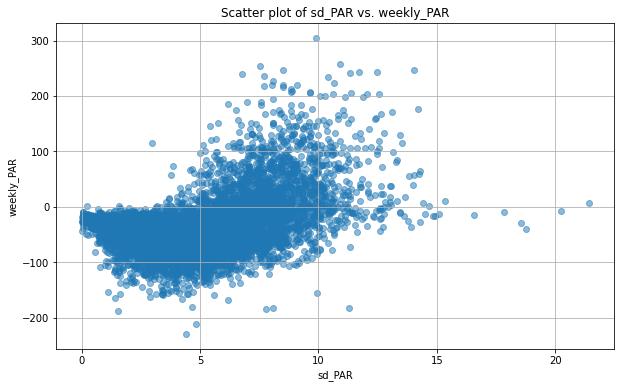

In [491]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(weekly_PAR_summary['sd_PAR'], weekly_summary['weekly_PAR'], alpha=0.5)
plt.title('Scatter plot of sd_PAR vs. weekly_PAR')
plt.xlabel('sd_PAR')
plt.ylabel('weekly_PAR')
plt.grid(True)
plt.show()

In [488]:
# moving all data back to the original all_data_df DataFrame
all_data_df = all_data_df_final_no_na_full_player_name.copy()

In [492]:
# Left join all_data_df with weekly_par
all_data_df = pd.merge(all_data_df, weekly_PAR_summary, on=['gsis_id', 'Season'], how='left')

# Replace NaN values in positive_weekly_PAR_summary and games_played columns with 0
all_data_df['positive_weekly_PAR'].fillna(0, inplace=True)
all_data_df['games_played'].fillna(0, inplace=True)

# Remove duplicate rows
all_data_df = all_data_df.drop_duplicates()

In [494]:
### ADD TEAM DATA
# Step 1: Filter pbp_data
filtered_pbp_data = pbp_data[(pbp_data['play_type'] != "No Play") & (pbp_data['posteam'] != 'NA')]

# Step 2: Group by and compute aggregated statistics
team_data = filtered_pbp_data.groupby(['posteam', 'Season']).agg(
    passYards=pd.NamedAgg(column='yards_gained', aggfunc=lambda x: x[filtered_pbp_data['pass_attempt'] == 1].sum()),
    passAttempts=pd.NamedAgg(column='pass_attempt', aggfunc='sum'),
    passTDs=pd.NamedAgg(column='touchdown', aggfunc=lambda x: x[filtered_pbp_data['pass_attempt'] == 1].sum()),
    rushYards=pd.NamedAgg(column='yards_gained', aggfunc=lambda x: x[filtered_pbp_data['rush_attempt'] == 1].sum()),
    rushAttempts=pd.NamedAgg(column='rush_attempt', aggfunc='sum'),
    rushTDs=pd.NamedAgg(column='touchdown', aggfunc=lambda x: x[filtered_pbp_data['rush_attempt'] == 1].sum())
).reset_index()

In [495]:
list(team_data)

['posteam',
 'Season',
 'passYards',
 'passAttempts',
 'passTDs',
 'rushYards',
 'rushAttempts',
 'rushTDs']

In [497]:
# Step 3: Left join all_data_df with team_data
all_data_df = pd.merge(all_data_df, team_data, left_on=['team', 'Season'], right_on=['posteam', 'Season'], how='left')

In [498]:
# Initialize the column with zeros
all_data_df['hasYearBefore'] = 0

# Iterate through each row of the dataframe
for idx, row in all_data_df.iterrows():
    gsis_id = row['gsis_id']
    full_player_name = row['full_player_name']
    next_season = row['Season'] + 1
    
    # Check if the player has a record in the next season based on gsis_id
    condition_by_id = (all_data_df['Season'] == next_season) & (all_data_df['gsis_id'] == gsis_id)
    count_by_id = len(all_data_df[condition_by_id])
    
    # Check if the player has a record in the next season based on full_player_name
    condition_by_name = (all_data_df['Season'] == next_season) & (all_data_df['full_player_name'] == full_player_name)
    count_by_name = len(all_data_df[condition_by_name])
    
    # Update the hasYearBefore column based on the results
    if count_by_id > 0:
        all_data_df.loc[condition_by_id, 'hasYearBefore'] = 1
    elif count_by_id == 0 and count_by_name > 0:
        all_data_df.loc[condition_by_name, 'hasYearBefore'] = 1


In [499]:
def get_next_season_points(row):
    # Get next season and the player's id and name
    next_season = row['Season'] + 1
    gsis_id = row['gsis_id']
    full_player_name = row['full_player_name']
    
    # Try to find the fantasy points for the next season using gsis_id
    val = all_data_df.loc[
        (all_data_df['Season'] == next_season) & (all_data_df['gsis_id'] == gsis_id), 
        'fantasyPoints'
    ].iloc[0] if len(all_data_df[
        (all_data_df['Season'] == next_season) & (all_data_df['gsis_id'] == gsis_id)
    ]) > 0 else None
    
    # If the above is unsuccessful, try using full_player_name
    if val is None:
        val = all_data_df.loc[
            (all_data_df['Season'] == next_season) & (all_data_df['full_player_name'] == full_player_name), 
            'fantasyPoints'
        ].iloc[0] if len(all_data_df[
            (all_data_df['Season'] == next_season) & (all_data_df['full_player_name'] == full_player_name)
        ]) > 0 else None

    return val if val is not None else 0

# Apply the function to each row of the dataframe
all_data_df['nextSeasonsPoints'] = all_data_df.apply(get_next_season_points, axis=1)


In [501]:
def get_next_season_team(row):
    # Get next season and the player's id
    next_season = row['Season'] + 1
    gsis_id = row['gsis_id']
    
    # Try to find the team for the next season using gsis_id
    team_next_season = all_data_df.loc[
        (all_data_df['Season'] == next_season) & (all_data_df['gsis_id'] == gsis_id), 
        'team'
    ]
    
    return team_next_season.iloc[0] if len(team_next_season) > 0 else "FA"

# Apply the function to each row of the dataframe
all_data_df['nextSeasonsTeam'] = all_data_df.apply(get_next_season_team, axis=1)


In [512]:
all_data_df[all_data_df["Season"]>=2017][["Season","full_player_name", "team", "games_played", "positive_weekly_PAR", "weekly_PAR", "fantasyPoints", "fantasy_points_8", "fantasy_points_4", "nextSeasonsPoints", "hasYearBefore"]].head(10)

,Season,full_player_name,team,games_played,positive_weekly_PAR,weekly_PAR,fantasyPoints,fantasy_points_8,fantasy_points_4,nextSeasonsPoints,hasYearBefore
2262,2017,Leonard Fournette,JAX,16.0,115.1,108.2,285.8,159.6,115.1,120.4,0
2263,2017,Le'Veon Bell,PIT,16.0,222.7,220.6,369.3,212.4,117.4,0.0,1
2264,2017,LeSean McCoy,BUF,17.0,135.1,119.3,277.5,148.7,90.0,125.2,1
2265,2017,Todd Gurley,LA,16.0,248.8,243.7,392.4,211.0,138.2,399.2,1
2266,2017,Melvin Gordon,LAC,16.0,146.5,133.9,292.1,140.0,90.4,290.8,1
2267,2017,Kareem Hunt,KC,17.0,159.4,150.7,308.9,139.9,106.2,230.2,0
2268,2017,Jordan Howard,CHI,16.0,79.0,41.5,199.7,89.7,57.6,181.5,1
2269,2017,Frank Gore,IND,16.0,31.7,9.4,167.6,95.3,55.5,100.6,1
2270,2017,Jay Ajayi,PHI,17.0,28.9,11.4,168.5,109.3,66.6,41.6,1
2271,2017,Mark Ingram,NO,18.0,128.7,122.3,284.3,164.0,78.6,150.4,1


In [513]:
# Step 1: Reordering and filtering columns
columns_to_keep = [col for col in all_data_df.columns if col not in ['Player_Name.x', 'Player_Name.y', 'Player_Name', 'Name', 'rusher_player_id', 'receiver_gsis', 'passer_gsis']]
data = all_data_df[columns_to_keep].sort_values(by="Season")
data['nextSeasonsPoints'] = data['nextSeasonsPoints'].astype(float)

# Step 2: Create new columns
data['firstFullYear'] = data.groupby('gsis_id')['Season'].transform('first') == data['Season']
data['isRookie'] = 0

# Step 3: Capture rookie data
rookies = data[data['firstFullYear'] | (data['hasYearBefore'] == 0)].copy()

# Step 4: Iterate and adjust values
for idx, row in rookies.iterrows():
    name = row['full_player_name']
    gsis_id = row['gsis_id']
    Season = row['Season']
    team = row['team']
    nextSeasonsTeam = row['team']
    nextSeasonsPoints = row['fantasyPoints']
    
    # Set all columns to 0
    rookies.loc[idx] = 0
    
    # Update specific columns
    rookies.at[idx, 'gsis_id'] = gsis_id
    rookies.at[idx, 'Season'] = Season - 1
    rookies.at[idx, 'team'] = team
    rookies.at[idx, 'nextSeasonsTeam'] = nextSeasonsTeam
    rookies.at[idx, 'nextSeasonsPoints'] = nextSeasonsPoints
    rookies.at[idx, 'isRookie'] = 1
    rookies.at[idx, 'full_player_name'] = name
    rookies.at[idx, 'position'] = str(rookies.at[idx, 'position'])
    
# Append to main dataframe
data = pd.concat([data, rookies])

# Step 5: Increment Season
data['Season'] = data['Season'] + 1
data2 = data.copy()


In [515]:
data2[["isRookie"]].head(10)

,isRookie
0,0
4513,0
4514,0
4515,0
4516,0
4517,0
4518,0
4519,0
4520,0
4521,0
